In [7]:
from Bio import Entrez
import time

# Set your email (required by NCBI)
Entrez.email = "your_email@example.com"

def search_pubmed(disease1, disease2, max_results=10):
    query = f"{disease1} AND {disease2}"
    
    # Search PubMed
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    handle.close()
    
    # Fetch article details
    ids = record["IdList"]
    num_articles = len(ids)
    
    print(f"\n🔍 Searching for: '{disease1}' AND '{disease2}'")
    print(f"📄 Found {num_articles} articles.")
    
    if not ids:
        print("❌ No articles found.")
        return
    
    handle = Entrez.esummary(db="pubmed", id=",".join(ids))
    records = Entrez.read(handle)
    handle.close()

    # Print articles
    for i, rec in enumerate(records, 1):
#         print(f"\n📝 Article {i}:")
        print(f"    📌 Title: {rec['Title']}")
#         print(f"📅 Date: {rec['PubDate']}")
#         print(f"🔗 DOI: {rec.get('DOI', 'N/A')}")
#         print(f"📚 Source: {rec['Source']}")
        

# List of diseases
disease_list = [ x.replace('_', ' ').replace('.', ' ') for x in [
    'lethal_midline_granuloma', 'oral_cavity_mucoepidermoid_carcinoma', 'major_salivary_gland_cancer',
    'inverted_papilloma', 'childhood_cancer', 'mast.cell_leukemia', 'appendix_carcinoma', 'Mastocytosis',
    'nuclear_senile_cataract', 'Orofaciodigital_syndrome_type_5', 'parotid_gland_cancer', 'paranasal_sinus_cancer',
    'Ovarian_Squamous_Cell_Carcinoma', 'neoplasm_of_hypopharynx', 'non.small_cell_squamous_lung_carcinoma',
    'DICER1.related_tumor_predisposition'
]]

# Run PubMed search for each disease against "childhood cancer"
for disease in disease_list:
    search_pubmed(disease, "childhood cancer")
    time.sleep(1)  # Sleep to prevent API rate limits
    print("-" * 80)



🔍 Searching for: 'lethal midline granuloma' AND 'childhood cancer'
📄 Found 1 articles.
    📌 Title: Centrofacial malignant T-cell lymphoma exhibiting recurrent fever and skin ulcer in a 3-year-old girl.
--------------------------------------------------------------------------------

🔍 Searching for: 'oral cavity mucoepidermoid carcinoma' AND 'childhood cancer'
📄 Found 9 articles.
    📌 Title: Parotid gland masses: outcomes in the pediatric age group.
    📌 Title: Rare tumors in pediatric age group: Single center experience from Saudi Arabia.
    📌 Title: Fine-Needle Aspiration Cytology Is an Effective Diagnostic Tool in Paediatric Patients with Mucoepidermoid Carcinoma as Secondary Neoplasm.
    📌 Title: Palatal mucoepidermoid carcinoma in a child.
    📌 Title: [Site and epidemiology of mucoepidermoid carcinoma. Analysis of 327 cases].
    📌 Title: Salivary gland neoplasms in children.
    📌 Title: Histopathologic review of salivary gland tumors in childhood.
    📌 Title: Mucoepiderm

--------------------------------------------------------------------------------

🔍 Searching for: 'nuclear senile cataract' AND 'childhood cancer'
📄 Found 1 articles.
    📌 Title: The Risk of Cataract among Survivors of Childhood and Adolescent Cancer: A Report from the Childhood Cancer Survivor Study.
--------------------------------------------------------------------------------

🔍 Searching for: 'Orofaciodigital syndrome type 5' AND 'childhood cancer'
📄 Found 0 articles.
❌ No articles found.
--------------------------------------------------------------------------------

🔍 Searching for: 'parotid gland cancer' AND 'childhood cancer'
📄 Found 10 articles.
    📌 Title: Medical Imagery: Cytomegalovirus sialadenitis in a patient with B-cell acute lymphoblastic leukemia.
    📌 Title: Impact of childhood/adolescent cancer history on prognosis in parotid mucoepidermoid carcinoma.
    📌 Title: Head and neck carcinoma in children: A clinicopathological study of 42 cases.
    📌 Title: Mucoe

🔍 glioblastoma multiforme: Found 352 articles.
🔍 lung adenocarcinoma: Found 36 articles.
🔍 neoplasm: Found 5102 articles.
🔍 cancer: Found 9999 articles.
🔍 endometrial cancer: Found 58 articles.
🔍 insulin resistance: Found 2151 articles.
🔍 Myocardial fibrosis: Found 41 articles.
🔍 Hyperglycemia: Found 562 articles.
🔍 Hepatic steatosis: Found 382 articles.
🔍 non alcoholic fatty liver disease: Found 148 articles.
🔍 intermittent vascular claudication: Found 4 articles.
🔍 Endometrial Intraepithelial Neoplasia: Found 1 articles.
🔍 Thiamine deficiency: Found 98 articles.
🔍 mouth neoplasm: Found 20 articles.
🔍 prediabetes syndrome: Found 53 articles.
🔍 aging: Found 9999 articles.
🔍 sex chromosome disorder of sex development: Found 18 articles.
🔍 Peri Implantitis: Found 3 articles.
🔍 Abnormal blood glucose concentration: Found 21 articles.
🔍 clear cell adenocarcinoma: Found 0 articles.


,Disease,Articles
0,glioblastoma multiforme,352
1,lung adenocarcinoma,36
2,neoplasm,5102
3,cancer,9999
4,endometrial cancer,58
5,insulin resistance,2151
6,Myocardial fibrosis,41
7,Hyperglycemia,562
8,Hepatic steatosis,382
9,non alcoholic fatty liver disease,148


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_44224/1560285578.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Articles", y="Disease", palette=colors[i], ax=ax)
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_44224/1560285578.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df_results['Disease'])


--------------------------------------------------------------------------------
🔍 lethal midline granuloma: Found 1 articles.
🔍 oral cavity mucoepidermoid carcinoma: Found 9 articles.
🔍 inverted papilloma: Found 4 articles.
🔍 mast cell leukemia: Found 15 articles.
🔍 appendix carcinoma: Found 20 articles.
🔍 Mastocytosis: Found 115 articles.
🔍 nuclear senile cataract: Found 1 articles.
🔍 Orofaciodigital syndrome type 5: Found 0 articles.
🔍 parotid gland cancer: Found 136 articles.
🔍 paranasal sinus cancer: Found 57 articles.
🔍 Ovarian Squamous Cell Carcinoma: Found 7 articles.
🔍 neoplasm of hypopharynx: Found 5 articles.
🔍 non small cell squamous lung carcinoma: Found 16 articles.
🔍 DICER1 related tumor predisposition: Found 29 articles.
🔍 supratentorial primitive neuroectodermal tumor: Found 104 articles.
🔍 ovary rhabdomyosarcoma: Found 13 articles.
🔍 extragonadal teratoma: Found 40 articles.
🔍 rhabdomyosarcoma of the cervix uteri: Found 4 articles.
🔍 uterine corpus rhabdomyosarcoma: F

,Disease,Articles
0,lethal midline granuloma,1
1,oral cavity mucoepidermoid carcinoma,9
2,inverted papilloma,4
3,mast cell leukemia,15
4,appendix carcinoma,20
5,Mastocytosis,115
6,nuclear senile cataract,1
7,Orofaciodigital syndrome type 5,0
8,parotid gland cancer,136
9,paranasal sinus cancer,57


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_44224/1560285578.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Articles", y="Disease", palette=colors[i], ax=ax)
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_44224/1560285578.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df_results['Disease'])


--------------------------------------------------------------------------------
🔍 dislocation: Found 499 articles.
🔍 CDKL5 disorder: Found 2 articles.
🔍 dental phobia: Found 23 articles.
🔍 cognition: Found 1849 articles.
🔍 Cannabis use: Found 38 articles.
🔍 Myoclonus: Found 22 articles.
🔍 Pituitary Gland Adenoma: Found 81 articles.
🔍 post operative sign or symptom: Found 9999 articles.
🔍 hypoxemia: Found 3222 articles.
🔍 lymphedema: Found 205 articles.
🔍 Hypothermia: Found 1837 articles.
🔍 brain disease: Found 9999 articles.
🔍 heart valve disease: Found 9999 articles.
🔍 Encephalopathy: Found 8731 articles.
🔍 Respiratory insufficiency: Found 1249 articles.
🔍 retinopathy: Found 676 articles.
🔍 avascular necrosis: Found 17 articles.
🔍 memory impairment: Found 240 articles.
🔍 postpartum depression: Found 27 articles.
🔍 acute respiratory failure: Found 386 articles.


,Disease,Articles
0,dislocation,499
1,CDKL5 disorder,2
2,dental phobia,23
3,cognition,1849
4,Cannabis use,38
5,Myoclonus,22
6,Pituitary Gland Adenoma,81
7,post operative sign or symptom,9999
8,hypoxemia,3222
9,lymphedema,205


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_44224/1560285578.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Articles", y="Disease", palette=colors[i], ax=ax)
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_44224/1560285578.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df_results['Disease'])


--------------------------------------------------------------------------------


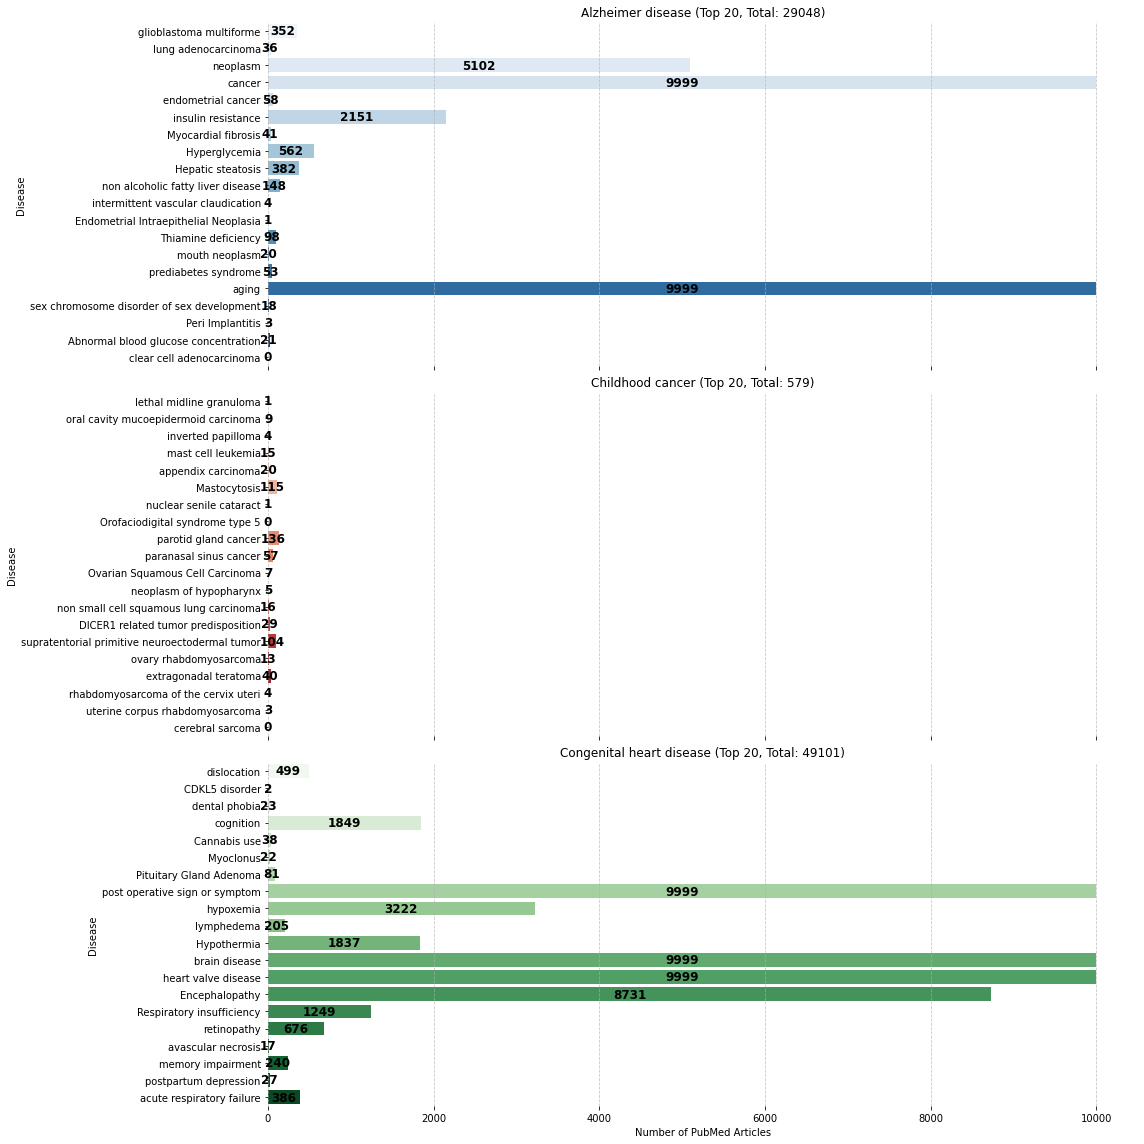

In [10]:
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez
from urllib.error import HTTPError
import time

# Set your email for NCBI Entrez API
Entrez.email = "your_email@example.com"

# Define CSV files with diseases
csv_files = {
    'Alzheimer disease': '../data/target_disease/ad_cor_20_0.955_gba_ranks.csv',
    'Childhood cancer': '../data/target_disease/childhoodcancer_cor_20_0.946_gba_ranks.csv',
    'Congenital heart disease': '../data/target_disease/chd_cor_20_0.888_gba_ranks.csv'
}

# csv_files = {
#     'Alzheimer disease': '../data/target_disease/ad_cor_20.csv',
#     'Childhood cancer': '../data/target_disease/childhoodcancer_cor_20.csv',
#     'Congenital heart disease': '../data/target_disease/chd_cor_20.csv'
# }

TOP_DISEASE_NUM = 20
# Function to search PubMed
def search_pubmed(disease1, disease2="childhood cancer", max_results=20_000):
    query = f"{disease1} AND {disease2}"
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    handle.close()

    num_articles = len(record["IdList"])
    print(f"🔍 {disease1}: Found {num_articles} articles.")
    return num_articles

def search_pubmed_with_retry(disease1, disease2="childhood cancer", max_results=20_000, retries=5, delay=0.5):
    query = f"{disease1} AND {disease2}"
    
    for attempt in range(retries):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
            record = Entrez.read(handle)
            handle.close()
            num_articles = len(record["IdList"])
            print(f"🔍 {disease1}: Found {num_articles} articles.")
            return num_articles
        
        except HTTPError as e:
            print(f"⚠️ HTTPError for query '{query}': {e}. Retrying in {delay} seconds...")
        except Exception as e:
            print(f"⚠️ Unexpected error for query '{query}': {e}. Retrying in {delay} seconds...")
        
        time.sleep(delay)
        delay *= 2  # Exponential backoff
    
    print(f"❌ Failed to fetch results for '{query}' after {retries} retries.")
    return 0  # Return 0 if all retries fail

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 16), sharex=True)
colors = ["Blues", "Reds", "Greens"]

# Process each CSV file
for i, (explored_disease, path) in enumerate(csv_files.items()):
    # Read first column (disease names)
    df = pd.read_csv(path, usecols=[0])  
    disease_list = df.iloc[:, 0].dropna().tolist()[:TOP_DISEASE_NUM]

    # Take first TOP_DISEASE_NUM diseases and format names
    disease_list = [x.replace('_', ' ').replace('.', ' ') for x in disease_list]

    # Query PubMed for each disease
    results = []
    for disease in disease_list:
        num_articles = search_pubmed_with_retry(disease, explored_disease)
        results.append({"Disease": disease, "Articles": num_articles})
        time.sleep(0.3)  # Sleep to prevent rate limiting

    # Convert to DataFrame and save results
    df_results = pd.DataFrame(results)
    df_results.to_csv(f"{explored_disease.replace(' ', '_')}_pubmed_results.csv", index=False)

    # Get total number of articles for TOP_DISEASE_NUM
    top_total = df_results["Articles"].sum()
    display(df_results)
    
    # Visualization
    ax = axes[i]
    sns.barplot(data=df_results, x="Articles", y="Disease", palette=colors[i], ax=ax)
    ax.set_xlabel("Number of PubMed Articles")
    ax.set_ylabel("Disease")
    ax.set_title(f"{explored_disease} (Top {TOP_DISEASE_NUM}, Total: {top_total})")
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    ax.set_yticklabels(df_results['Disease'])
    ax.set_frame_on(False)
    
    # Add value in the middle of each bar
    for p in ax.patches:
        width = p.get_width()
        ax.text(width / 2, p.get_y() + p.get_height() / 2, f'{int(width)}',
                ha='center', va='center', fontsize=12, color='black', fontweight='bold')
    print('-' * 80)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("pubmed_results.png", dpi=300)
plt.show()